# KOI 2124  -  SpecMatch-Emp

Fit stellar Teff and estimate mass using SpecMatch-Emp


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.transforms import blended_transform_factory
from astropy.io import fits, ascii
import os, sys
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use('katie') 
from os import getcwd
#import spectres

In [16]:
# specmatch specific packages
import pandas as pd
from pylab import *
import specmatchemp.library
import specmatchemp.plots as smplot
from specmatchemp import spectrum
from specmatchemp.specmatch import SpecMatch

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,6
plt.rcParams['figure.dpi'] = 200

## 1. Read in observed spectrum

May need to run twice to get rid of error

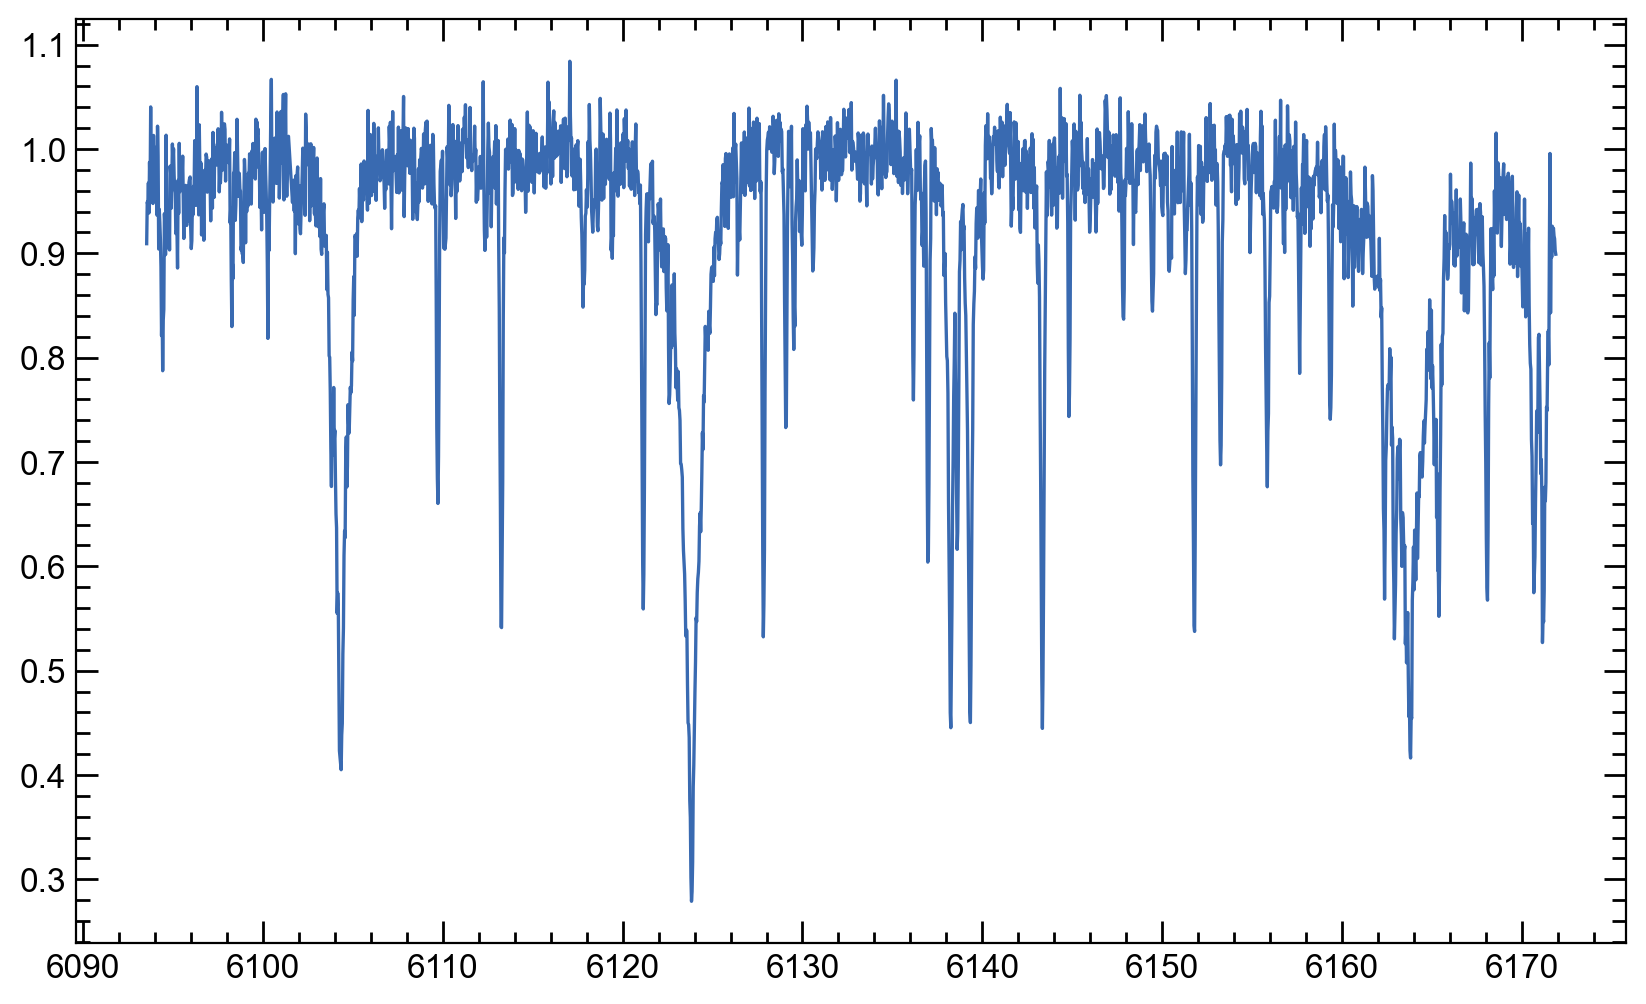

FileNotFoundError: [Errno 2] No such file or directory: 'cks-k01961_rj134.196.fits'

In [21]:
# Observed HIRES spectra
#print('Reading in observations...')
#print(' ')
star = 'KOI2124'
var = np.load('neid_spectrum_avg2.npz')
w = np.array(var['w'] )   #wave, order
s = np.array(var['rs'])   #wave, order, night
no = len(w[0,:])
nw = len(w[:,0])
nsp = 1

order = 61
plt.plot(w[:, order], s[:, order])
plt.show()
plt.close()
# Load obs into a "spectrum" object
from specmatchemp import spectrum
#obs = specmatchemp.spectrum.Spectrum(w[:,order], s[:,order], name=star).cut(6090,6180)  
# this cut range matters! need padding or else shift & match won't work
# ExoFOP uses Mg b triplet 5167, 5172, 5183 A



# specmatch can read hires directly!
obs = spectrum.read_hires_fits('cks-k01961_rj134.196.fits').cut(5130,5210)
obs.name = star


## 2. Load the library of empirical stellar spectra

Choose which templates we want to use --> Teff = 3400 - 5500 K

Reading library from /Users/klester/.specmatchemp/library.h5


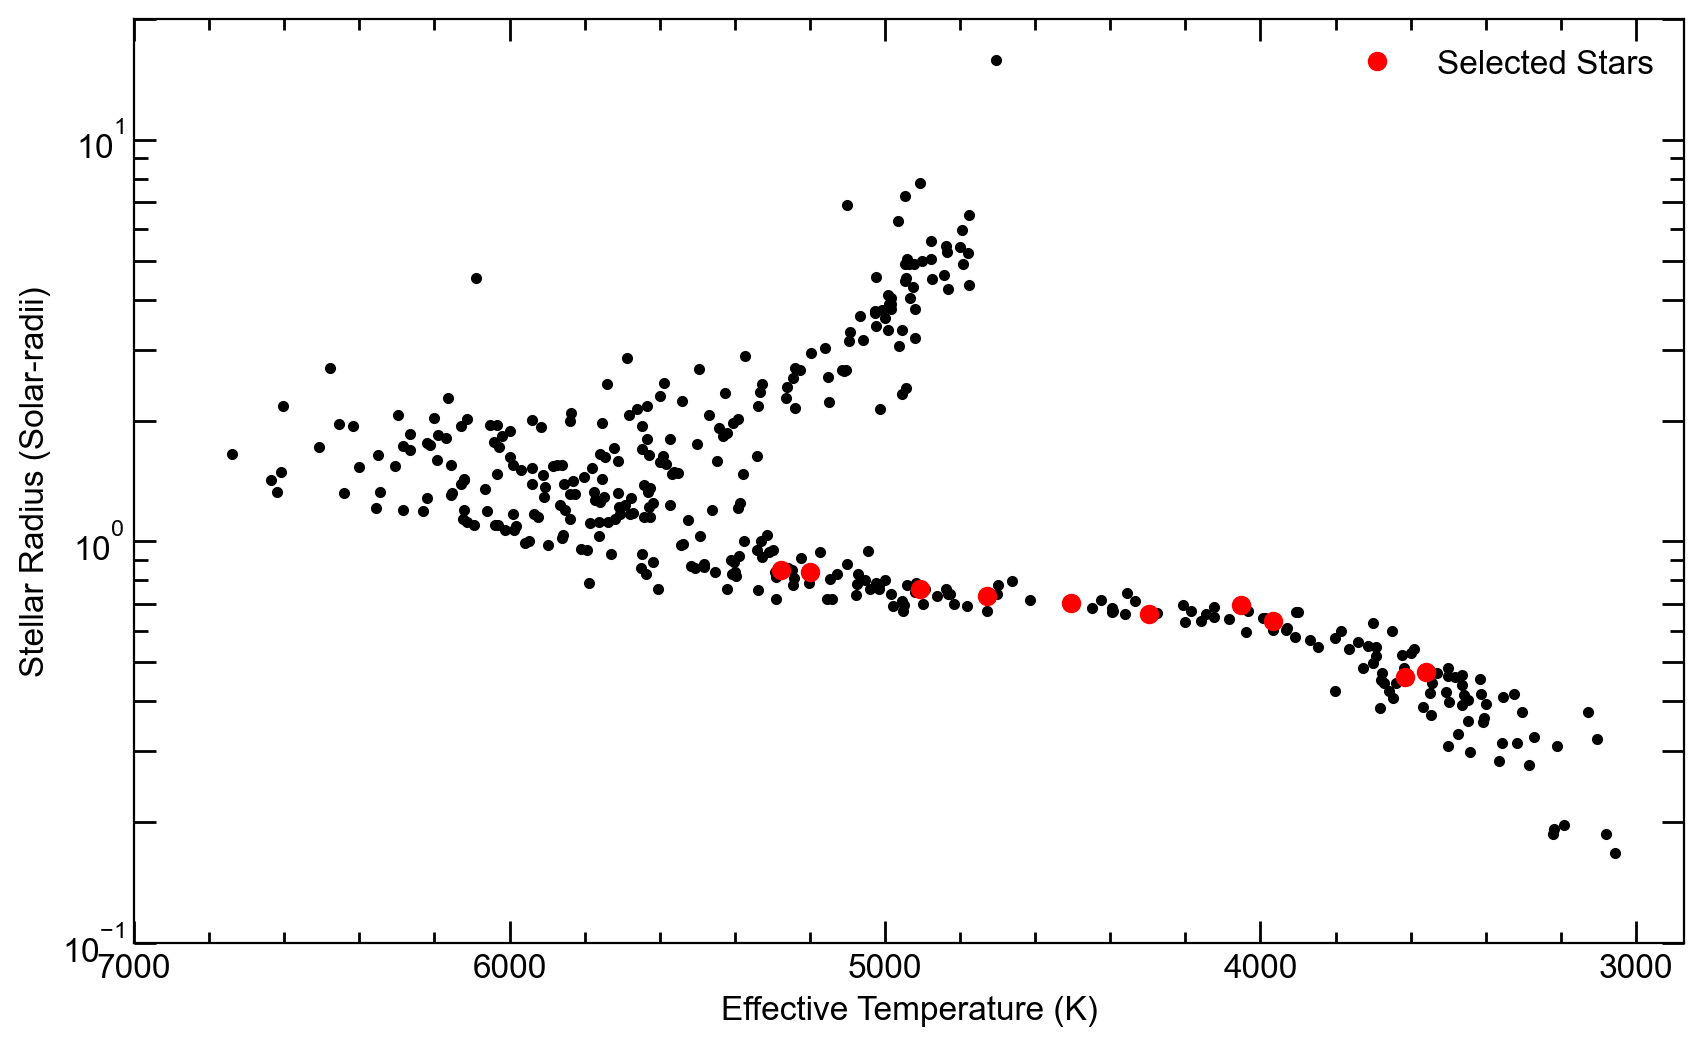

In [22]:
# Load the library
lib = specmatchemp.library.read_hdf(wavlim=[5130,5210])

# initial guess match
idx1 = lib.get_index('HIP15095')
test_star = lib.pop(idx1)

# pull stars with range of Teff
cut = lib.library_params.query('radius < 1.5 and -0.25 < feh < 0.25')
g = cut.groupby(pd.cut(cut.Teff,bins=arange(3400,5500,200)),observed=True)
cut = g.first()

fig = figure()
plot(lib.library_params.Teff, lib.library_params.radius,'k.', label='_nolegend_')
plot(cut.Teff, cut.radius,'ro', label='Selected Stars')
legend()
smplot.label_axes('Teff','radius')
fig.savefig('specmatch_hrdiagram.png', bbox_inches='tight', dpi=300)


## 3. Shifting to match templates RV=0

Our observed spectrum is shifted due to its RV, so we need to fit and correct for this shift using the SpecMatch.shift() function.

This method runs a cross-correlation between the target spectrum and several reference spectra in the library for a select region of the spectrum. The reference spectrum which gives the largest cross-correlation peak is then used to shift the entire spectrum.

We make use of the spectrum.Spectrum.plot() method to quickly plot each of the unshifted, shifted and reference spectra. Note that HIRES has overlapping orders so some spectral lines appear twice. In the final resampled spectrum, the small segments of overlapping orders are averaged.


In [23]:
sm_obs = SpecMatch(obs, lib)
sm_obs.shift()  


Shifting spectrum
Shifting spectrum KOI2124
Attempting shift to spectrum NSO, median cross-correlation peak = 0.61


/opt/anaconda3/envs/astroconda/lib/python3.9/site-packages/SpecMatch_Emp-0.3-py3.9.egg/specmatchemp/shift.py:254: RuntimeWarning: Mean of empty slice
  lag_data[0, j] = np.nanmean([lag_data[0, j - 1],


ValueError: Residuals are not finite in the initial point.

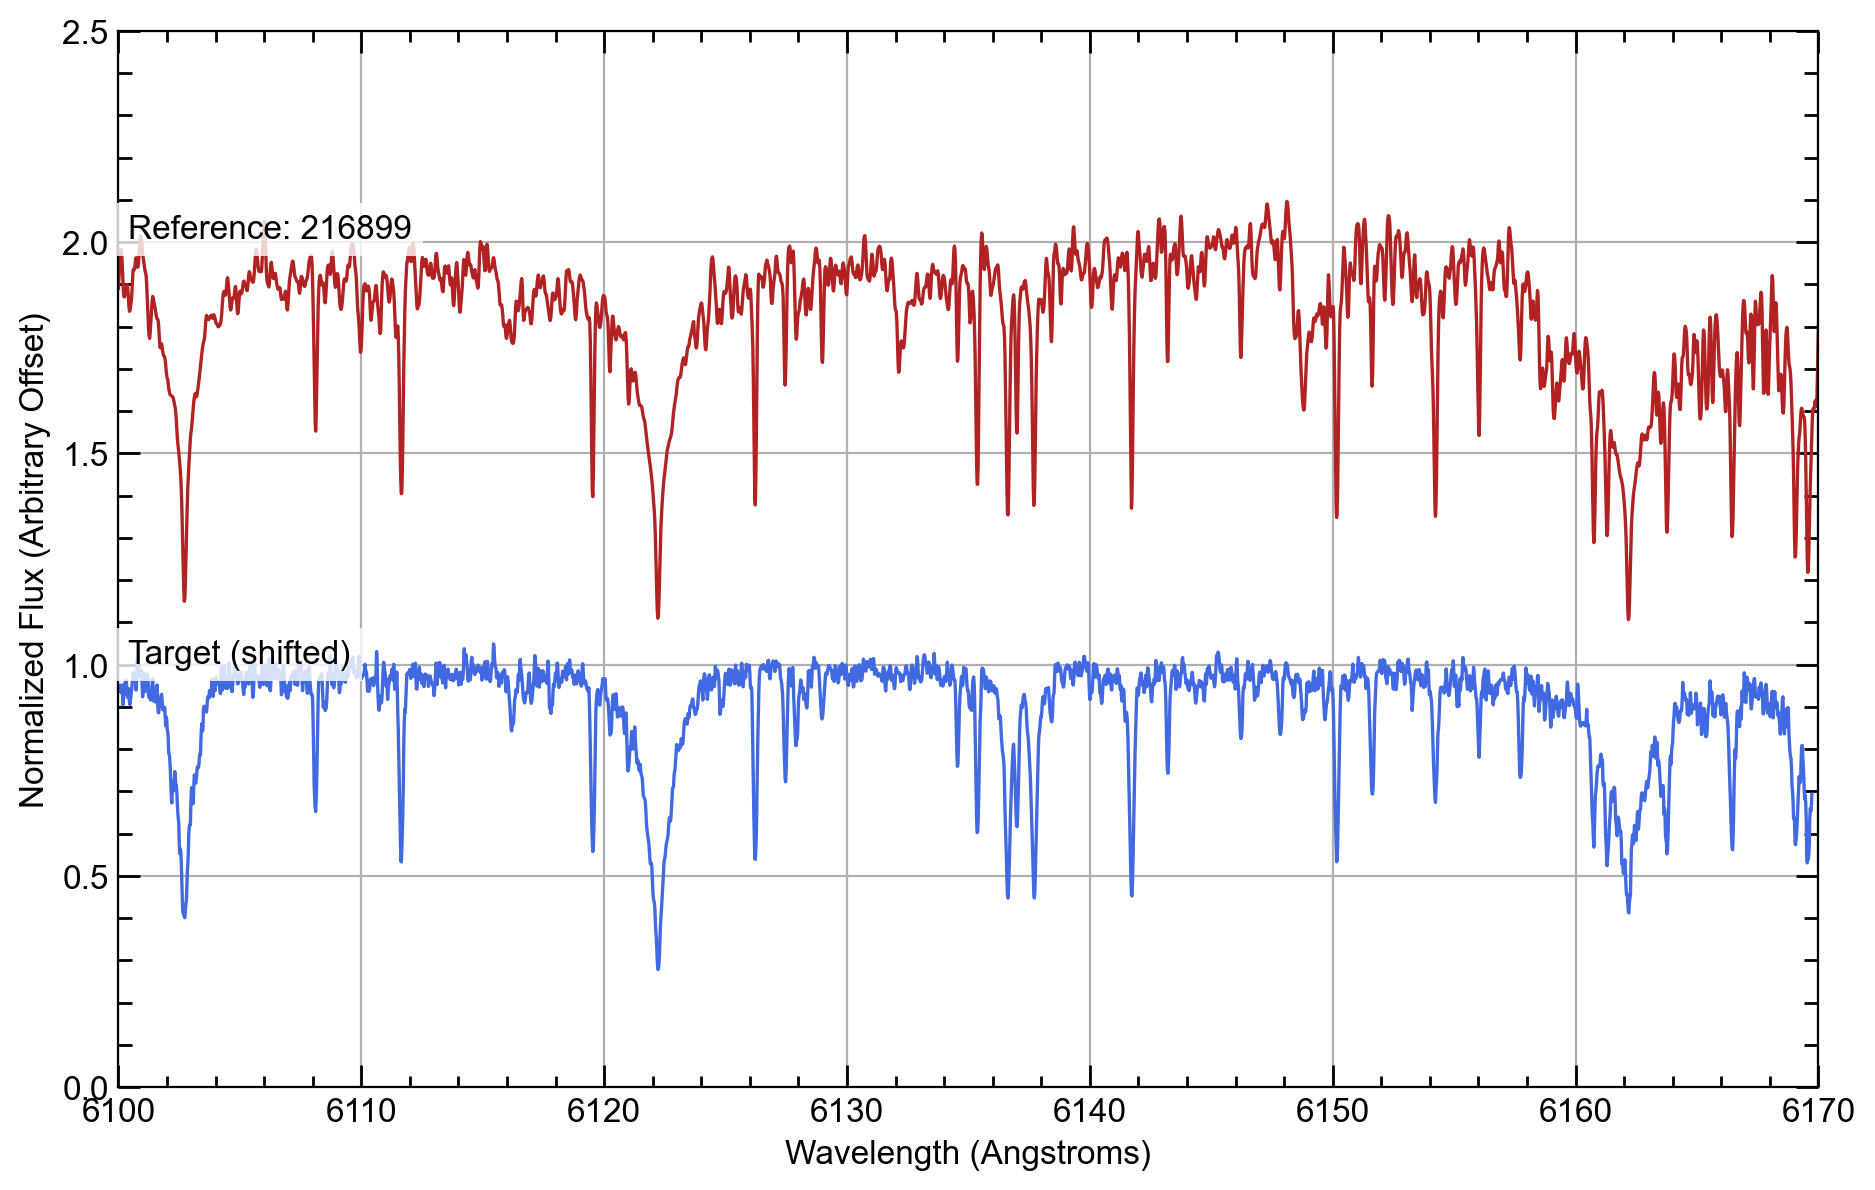

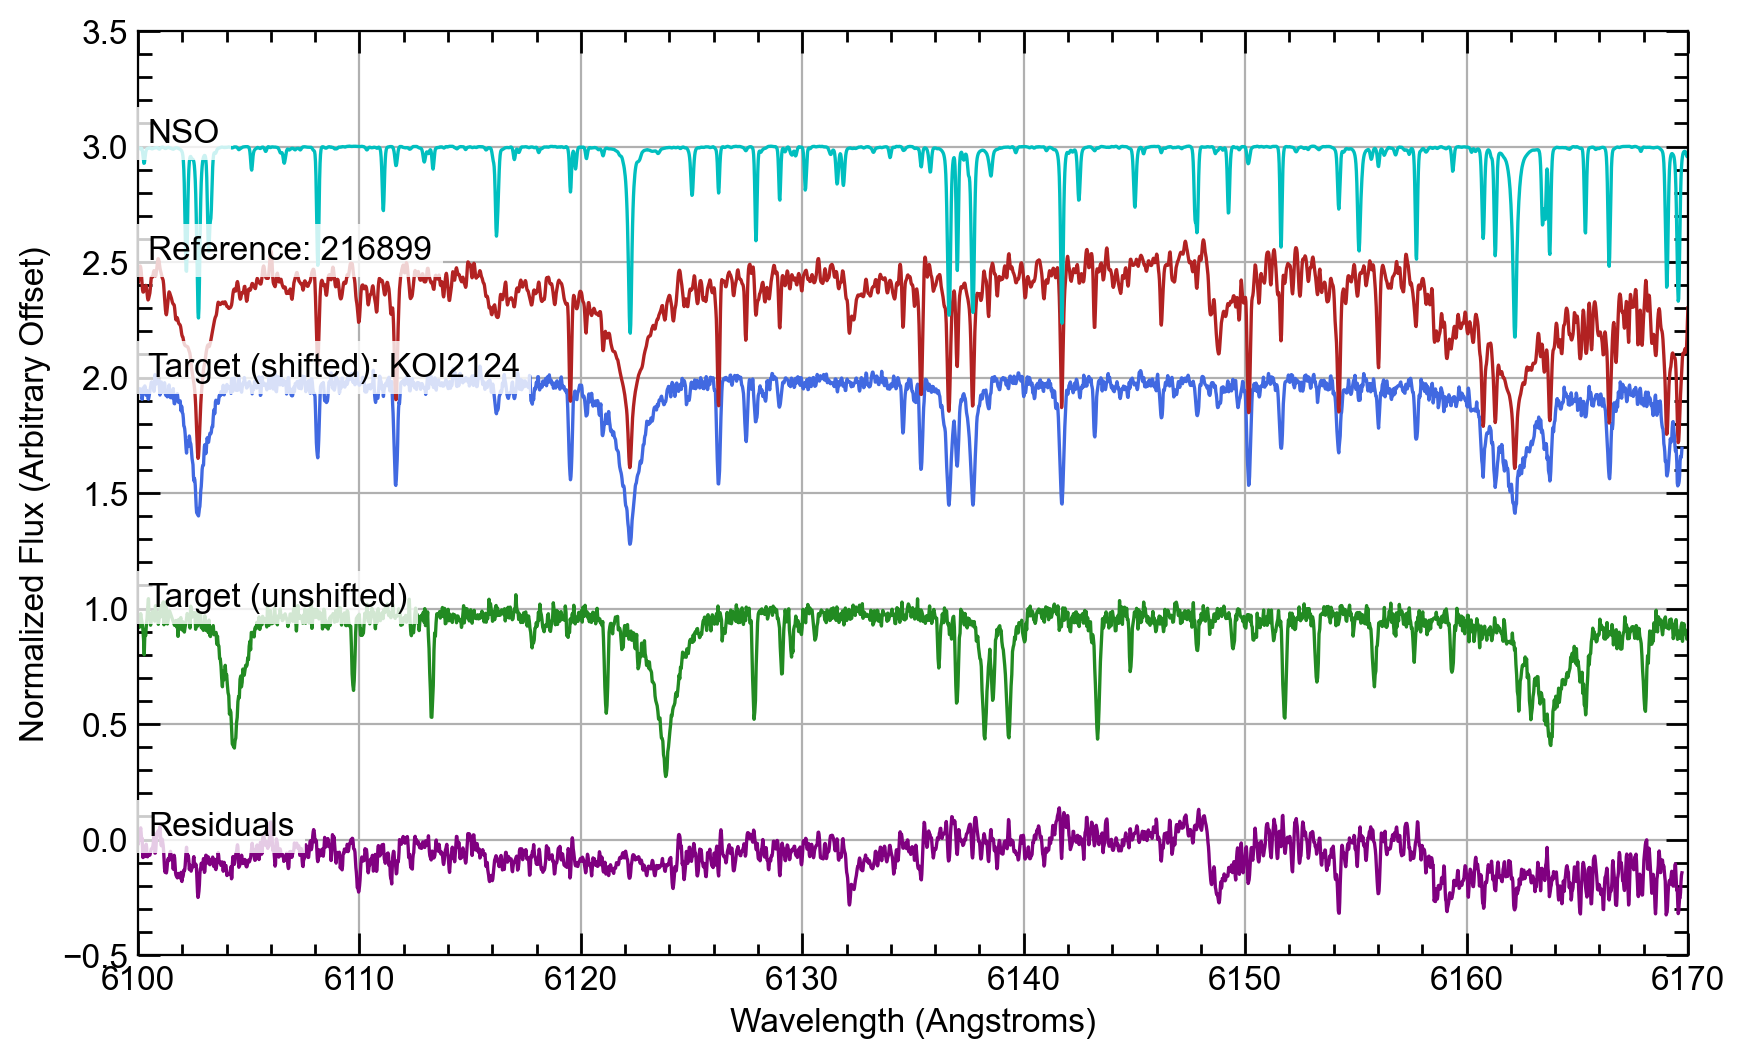

In [7]:
# plot shifted spectrum
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.10, 0.10, 0.85, 0.88])  
#sm_obs.target_unshifted.plot(normalize=True, plt_kw={'color':'forestgreen'}, text='Target (unshifted)')
sm_obs.target.plot(offset=0.0, plt_kw={'color':'royalblue'}, text='Target (shifted)')
sm_obs.shift_ref.plot(offset=1.0, plt_kw={'color':'firebrick'}, text='Reference: '+sm_obs.shift_ref.name)
plt.xlim(6100,6170)
plt.ylim(0,2.5)
plt.show()
plt.close()


sm_obs.plot_shifted_spectrum(wavlim=(6100,6170))

## 4. Matching to get stellar parameters

 Now, we can perform the match. We first run SpecMatch.match(), which performs a match between the target and every other star in the library, allowing v sin i to float and fitting a spline to the continuum.

 We can then plot the chi-squared surfaces to see where the best matches lie in parameter space.

 ### first try to find best match in library

In [8]:
# do the match  (ignore the errors & wait for it to finish)
sm_obs.match(wavlim=(6090,6180))


Matching spectrum
Matching region (6090, 5900)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Plot chi-squared surfaces
sm_obs.plot_chi_squared_surface()
axes = fig.axes
plt.savefig('specmatch_match_chi2.png', bbox_inches='tight', dpi=300)


### Linear combination to get exact fit


Typical [uncertainties](https://nexsci.caltech.edu/conferences/2017/knowthystar/SpecMatch-Emp_KnowThyStar.pdf):  100 K in temperature, 15% in Fe/H, and 0.12 in radius

In [ ]:
sm_obs.lincomb()

print('')
print('Derived Parameters: ')
print('Teff: {0:.0f}, Radius: {1:.2f}, [Fe/H]: {2:.2f}'.format( sm_obs.results['Teff'], sm_obs.results['radius'], sm_obs.results['feh']))
print('')

teff = sm_obs.results['Teff']
feh = sm_obs.results['feh']
radius = sm_obs.results['radius']

In [ ]:
# Plot HR diagram
fig1 = figure(figsize=(12, 10))
sm_obs.plot_references(verbose=True)
axes = fig1.axes
axes[0].legend(numpoints=1, fontsize='small', loc='best')
plt.savefig('specmatch_lincomb_hr.png', bbox_inches='tight', dpi=300)


In [ ]:
# errors from range of params of best matches, based on looking at plots
eTeff = abs(3750 - 3600)/2
eFeH = abs(-0.2 - 0.25)/2
eradius = abs(0.52 - 0.56)/2


In [ ]:


# Plot reference spectra and linear combinations
fig2 = plt.figure(figsize=(12,8))
sm_obs.plot_lincomb()
plt.savefig('specmatch_lincomb.png', bbox_inches='tight', dpi=300)


## 5. Find corresponding mass

Using Mamajek table of stellar parameters

In [ ]:
# Read in M-T-R relations of Pecault & Mamajek (2013):
stdstars_all = ascii.read('~/Research/bin/EEM_dwarf_UBVIJHK_colors_Teff.csv', format='csv', data_start=6)

# Cut down to spectral types B0 - M9, so have real values for M, R, etc.
real = np.where((stdstars_all["Teff"] > 3000) & (stdstars_all["Teff"] < 20000))
stdstars = stdstars_all[real]
print(stdstars)

tmod = np.flip(np.array(stdstars["Teff"], dtype=float))
mmod = np.flip(np.array(stdstars["Msun"], dtype=float))
vmod = np.flip(np.array(stdstars["Mv"], dtype=float))


In [ ]:
# Find closest model by Teff
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx   
i1 = find_nearest(tmod, teff)     #index for closest spectral type by Teff


# interpolate primary mass
#ynew = np.interp(xnew, xp, yp)
mass1 = np.interp(teff, tmod, mmod)
print('M1 = ', mass1, ' Msun')


# secondary mass from 832 dmag
dmag = 0.5
v1 = vmod[i1]
v2 = v1 + dmag
#mass2 = np.interp(v2, vmod, mmod)  # doesn't work
i2 = find_nearest(vmod, v2)     #index for closest spectral type by Teff
mass2 = mmod[i2]

print('M2 = ', mass2, ' Msun')
print('Mtot = ', mass1+mass2, ' Msun')


## 6. Write results to file

In [ ]:
f = open("specmatch_results2.txt", "w")
f.write('Derived Parameters: \n')
f.write('Teff     K     %5.0f %5.0f \n'%(teff, eTeff))
f.write('[Fe/H]   dex   %5.2f %5.2f \n'%(feh, eFeH))
f.write('Radius   Rsun  %5.2f %5.2f \n'%(radius, eradius))
f.write('M1       Msun  %5.2f %5.2f \n'%(mass1, 0))
f.write('M2       Msun  %5.2f %5.2f \n'%(mass2, 0))
f.write('Mtot     Msun  %5.2f %5.2f \n'%(mass1+mass2, 0))
f.close()